## MICCAI PLS Baseline

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-01-25 14:46:59.571671: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-25 14:47:00.931334: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-25 14:47:02.752424: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from models import *
from data import * 
from env import *
from harmonize import *
from sim import *

In [4]:
# overall imports
import importlib
import data

from sim.sim import Simulation
from sim.sim_utils import bytes2human, print_system_usage

# data load
import data.data_utils
from data.data_load import load_transcriptome, load_connectome, load_coords
from data.data_viz import plot_connectome, plot_connectome_with_labels, plot_transcriptome

# data utils
from data.data_utils import (
    reconstruct_connectome,
    reconstruct_upper_triangle,
    make_symmetric,
    expand_X_symmetric,
    expand_Y_symmetric,
    expand_X_symmetric_shared,
    expand_shared_matrices,
    process_cv_splits,  
    expanded_inner_folds_combined_plus_indices
)

import models
import models.metrics
from models.metrics import *

In [5]:
print_system_usage()
total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 73.6%
RAM Usage: 31.3%
Available RAM: 258.9G
Total RAM: 377.1G
52.4G


## Specify connectome and transcriptome

Full brain HCP Enigma

In [30]:
HCP_enigma_structural_count, HCP_enigma_labels, HCP_enigma_lh_indices, HCP_enigma_rh_indices = load_connectome(measure='SC', omit_subcortical=False, include_labels=True, diag=0)
HCP_enigma_functional_conn = load_connectome(measure='FC', omit_subcortical=False)
HCP_coords = load_coords(parcellation='S100', omit_subcortical=False)
HCP_coords_left = load_coords(parcellation='S100', omit_subcortical=False, hemisphere='left')
HCP_coords_right = load_coords(parcellation='S100', omit_subcortical=False, hemisphere='right')
AHBAS100_transcriptome = load_transcriptome(parcellation='S100', omit_subcortical=False)

Full brain HCP1200 and UKBB

In [7]:
HCP1200_structural_count, HCP1200_labels, HCP1200_lh_indices, HCP1200_rh_indices = load_connectome(measure='SC', parcellation='S400', omit_subcortical=False, include_labels=True, diag=1)
HCP1200_functional_conn = load_connectome(measure='FC', parcellation='S400', omit_subcortical=False)
HCP1200_coords = load_coords(parcellation='S400', omit_subcortical=False)
AHBAS400_transcriptome = load_transcriptome(parcellation='S400', omit_subcortical=False)

Assign features and targets

In [31]:
X = AHBAS100_transcriptome
Y_sc = HCP_enigma_structural_count
Y_fc = HCP_enigma_functional_conn
Y = Y_fc

left_coords = HCP_coords_left
right_coords = HCP_coords_right

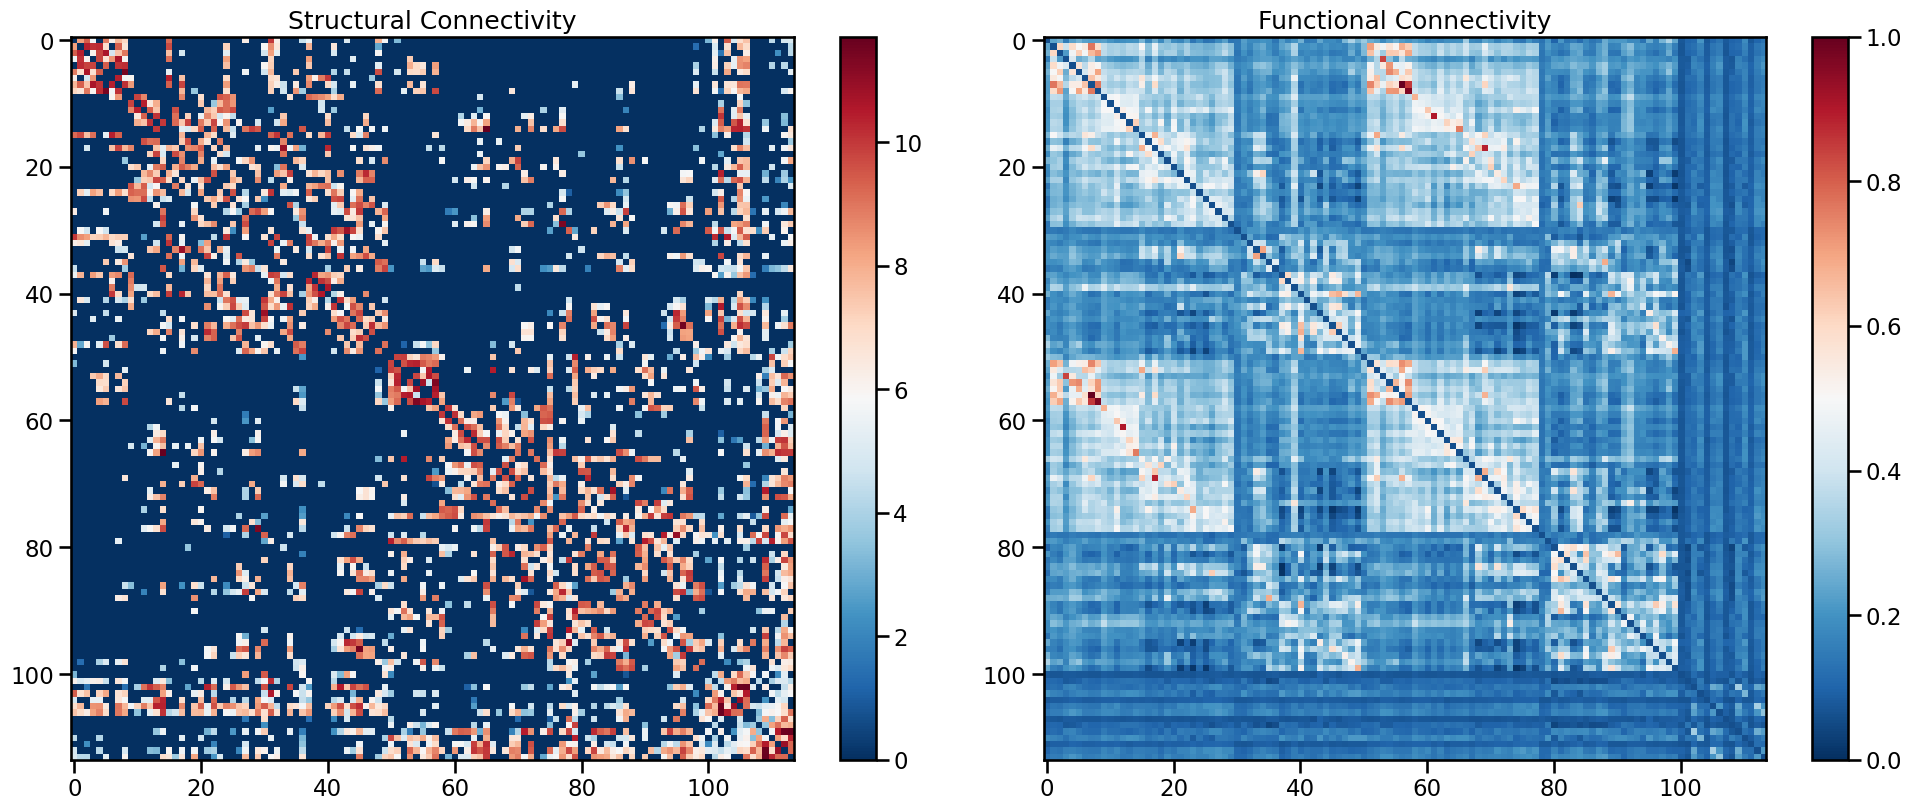

In [32]:
# Visualize structural and functional connectivity matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

im1 = ax1.imshow(Y_sc, cmap='RdBu_r')
ax1.set_title('Structural Connectivity')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(Y_fc, cmap='RdBu_r')
ax2.set_title('Functional Connectivity') 
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()


## Fit PLS model

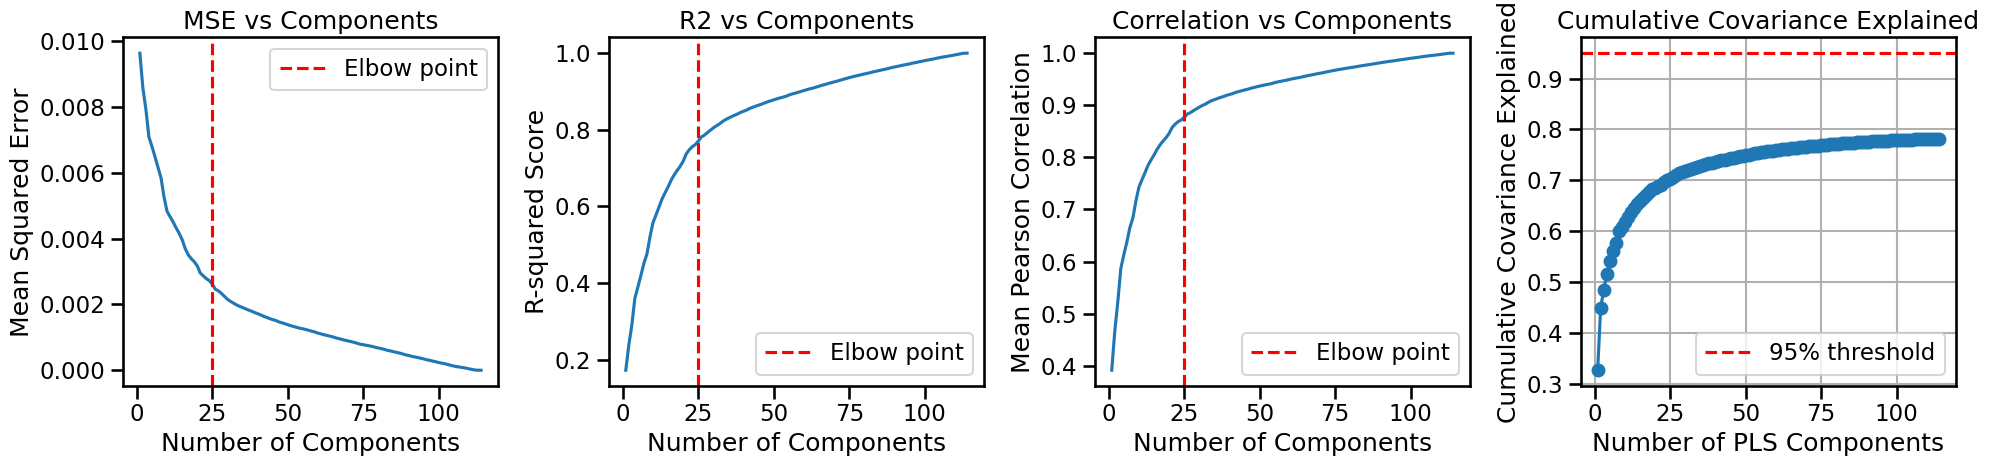

Best model performance (at elbow point):
Number of components: 25
MSE: 0.0026
R2: 0.7703
Mean correlation: 0.8768


In [25]:
def get_best_pls_model(X, Y, max_components=25):
    """
    Evaluate PLS models and return the best one based on correlation score and elbow point.
    
    Args:
        X: Input features array
        Y: Target array
        max_components: Maximum number of components to try
        
    Returns:
        PLSRegression: Best performing PLS model
        dict: Dictionary containing performance metrics
    """
    # Initialize lists to store metrics
    mse_scores = []
    r2_scores = []
    corr_scores = []
    models = []

    # Try different numbers of components
    for n_comp in range(1, max_components + 1):
        # Fit PLS model
        pls = PLSRegression(n_components=n_comp)
        pls.fit(X, Y)
        models.append(pls)
        
        # Make predictions
        Y_pred = pls.predict(X)
        
        # Calculate metrics
        mse = mean_squared_error(Y, Y_pred)
        r2 = r2_score(Y, Y_pred)
        
        # Calculate Pearson correlation for each connection
        correlations = []
        for i in range(Y.shape[1]):
            r = pearsonr(Y[:, i], Y_pred[:, i])[0]
            correlations.append(r)
        mean_correlation = np.mean(correlations)
        
        # Store metrics
        mse_scores.append(mse)
        r2_scores.append(r2)
        corr_scores.append(mean_correlation)

    # Find elbow point using kneedle algorithm
    x = np.array(range(1, max_components + 1))
    y = np.array(corr_scores)
    
    # Normalize data for knee detection
    x_normalized = (x - min(x)) / (max(x) - min(x))
    y_normalized = (y - min(y)) / (max(y) - min(y))
    
    # Find knee point
    kn = KneeLocator(x_normalized, y_normalized, curve='concave', direction='increasing')
    elbow_idx = int(kn.knee * max_components) - 1  # Convert back to original scale
    
    # Use elbow point as best model
    best_model = models[elbow_idx]
    
    # Store metrics in dictionary
    metrics = {
        'n_components': elbow_idx + 1,
        'mse': mse_scores[elbow_idx],
        'r2': r2_scores[elbow_idx],
        'correlation': corr_scores[elbow_idx]
    }
    
    # Plot metrics
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].plot(range(1, max_components + 1), mse_scores)
    axes[0].axvline(x=elbow_idx + 1, color='r', linestyle='--', label='Elbow point')
    axes[0].set_xlabel('Number of Components')
    axes[0].set_ylabel('Mean Squared Error')
    axes[0].set_title('MSE vs Components')
    axes[0].legend()

    axes[1].plot(range(1, max_components + 1), r2_scores)
    axes[1].axvline(x=elbow_idx + 1, color='r', linestyle='--', label='Elbow point')
    axes[1].set_xlabel('Number of Components')
    axes[1].set_ylabel('R-squared Score')
    axes[1].set_title('R2 vs Components')
    axes[1].legend()

    axes[2].plot(range(1, max_components + 1), corr_scores)
    axes[2].axvline(x=elbow_idx + 1, color='r', linestyle='--', label='Elbow point')
    axes[2].set_xlabel('Number of Components')
    axes[2].set_ylabel('Mean Pearson Correlation')
    axes[2].set_title('Correlation vs Components')
    axes[2].legend()

    # Calculate and plot covariance explained for all components
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    Y_scaled = scaler_Y.fit_transform(Y)

    # Compute total covariance between X and Y
    total_covariance = np.sum(np.cov(X_scaled.T, Y_scaled.T, bias=True)[0:len(X_scaled.T), len(X_scaled.T):])
    
    # Calculate cumulative covariance explained for each number of components
    covariance_explained = []
    for n_comp in range(1, max_components + 1):
        pls = PLSRegression(n_components=n_comp)
        pls.fit(X_scaled, Y_scaled)
        X_scores = pls.x_scores_
        Y_scores = pls.y_scores_
        cov_sum = np.sum([np.cov(X_scores[:, i], Y_scores[:, i])[0, 1] for i in range(X_scores.shape[1])])
        covariance_explained.append(cov_sum / total_covariance)

    axes[3].plot(range(1, max_components + 1), covariance_explained, marker='o')
    axes[3].set_xlabel('Number of PLS Components')
    axes[3].set_ylabel('Cumulative Covariance Explained')
    axes[3].set_title('Cumulative Covariance Explained')
    
    # Add horizontal line at 95% covariance explained
    axes[3].axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
    
    # Find where 95% threshold is crossed
    threshold_idx = next((i for i, x in enumerate(covariance_explained) if x >= 0.95), None)
    if threshold_idx is not None:
        axes[3].axvline(x=threshold_idx + 1, color='g', linestyle='--', 
                       label=f'95% reached at {threshold_idx + 1} components')
    
    axes[3].grid(True)
    axes[3].legend()

    plt.tight_layout()
    plt.show()

    print(f"Best model performance (at elbow point):")
    print(f"Number of components: {metrics['n_components']}")
    print(f"MSE: {metrics['mse']:.4f}")
    print(f"R2: {metrics['r2']:.4f}")
    print(f"Mean correlation: {metrics['correlation']:.4f}")
    
    return best_model, metrics
    

# Get best PLS model
max_components = min(X.shape[1], Y.shape[1]) # max possible components
# max_components = 30
# max_components = 25
best_pls_model, metrics = get_best_pls_model(X, Y, max_components)


In [26]:
# Print dimensionality of PLS parameters
print("PLS Model Parameter Dimensions:")
print("\nWeights:")
print(f"X weights: {best_pls_model.x_weights_.shape} - Left singular vectors of cross-covariance matrices")  
print(f"Y weights: {best_pls_model.y_weights_.shape} - Right singular vectors of cross-covariance matrices")

print("\nLoadings:")
print(f"X loadings: {best_pls_model.x_loadings_.shape} - Loadings/coefficients for X features")
print(f"Y loadings: {best_pls_model.y_loadings_.shape} - Loadings/coefficients for Y targets")

print("\nScores:")
print(f"X scores: {best_pls_model.x_scores_.shape} - Transformed X samples in latent space") 
print(f"Y scores: {best_pls_model.y_scores_.shape} - Transformed Y targets in latent space")

print("\nRotations:")
print(f"X rotations: {best_pls_model.x_rotations_.shape} - Projection matrix for transforming X")
print(f"Y rotations: {best_pls_model.y_rotations_.shape} - Projection matrix for transforming Y")

print("\nCoefficients and Intercepts:")
print(f"Coefficients: {best_pls_model.coef_.shape} - Coefficients for predicting Y from X")
print(f"Intercepts: {best_pls_model.intercept_.shape} - Intercept terms for predictions")


PLS Model Parameter Dimensions:

Weights:
X weights: (10760, 25) - Left singular vectors of cross-covariance matrices
Y weights: (114, 25) - Right singular vectors of cross-covariance matrices

Loadings:
X loadings: (10760, 25) - Loadings/coefficients for X features
Y loadings: (114, 25) - Loadings/coefficients for Y targets

Scores:
X scores: (114, 25) - Transformed X samples in latent space
Y scores: (114, 25) - Transformed Y targets in latent space

Rotations:
X rotations: (10760, 25) - Projection matrix for transforming X
Y rotations: (114, 25) - Projection matrix for transforming Y

Coefficients and Intercepts:
Coefficients: (114, 10760) - Coefficients for predicting Y from X
Intercepts: (114,) - Intercept terms for predictions


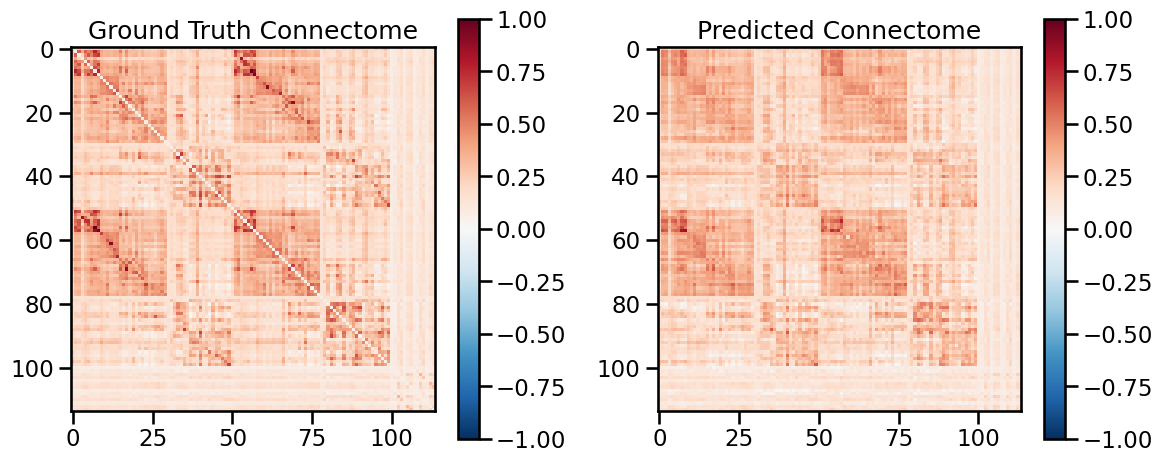

In [33]:
# Get predictions and ground truth
Y_pred = best_pls_model.predict(X)
Y_true = Y

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot ground truth connectome
im1 = ax1.imshow(Y_true, cmap='RdBu_r', vmin=-1, vmax=1)
ax1.set_title('Ground Truth Connectome')
plt.colorbar(im1, ax=ax1)

# Plot predicted connectome  
im2 = ax2.imshow(Y_pred, cmap='RdBu_r', vmin=-1, vmax=1)
ax2.set_title('Predicted Connectome')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()


permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000


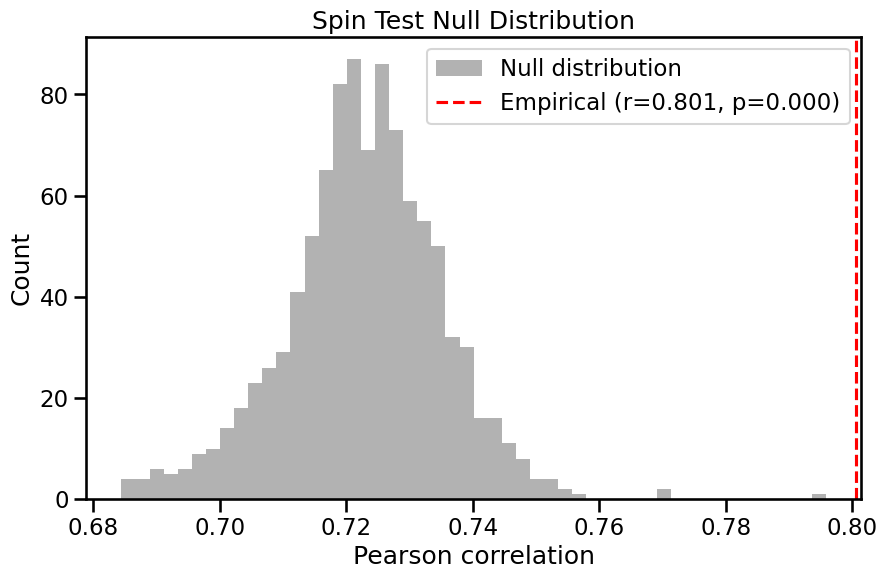

In [76]:
# Spatial null model
'''
- Idea is that autocorrelation in gene expression, X, is driving the PLS solution
- To address this we can generate a spatial permutation of either the gene expression data or the connectome data an refit the PLS model
- Here we will permute the target data as in Hansen, 2021

- The spin test embodies the null hypothesis that genes and connectivity values are spatially correlated with each other because of inherent spatial autocorrelation.
- In Hansen, 2021, the P value is computed as the proportion of null singular values that are greater in magnitude than the empirical singular values.
- Thus, the P value represents the probability that the observed spatial correspondence between genes and connectivity values could occur by randomly correlating maps with comparable spatial autocorrelation

- In our case the null distribution could be the pearson-r values (or other metrics) of the best PLS model as determined by elbow point. 
'''

# Number of permutations for null distribution
n_perms = 1000

# Refit PLS model with optimal number of components
n_components = 9 # best_pls_model.n_components
best_pls_model = PLSRegression(n_components=n_components)
best_pls_model.fit(X, Y_true)

# Calculate empirical correlation
Y_pred_empirical = best_pls_model.predict(X)
empirical_corr = pearsonr(Y_true.flatten(), Y_pred_empirical.flatten())[0]

# Generate all rotations beforehand
rotated_ids = rotate_parcellation(left_coords, right_coords, nrot=n_perms)  # shape = (m, nrot)
rotated_ids = rotated_ids.astype(int)

# Initialize array to store null correlations
null_corrs = np.zeros(n_perms)

# Generate null distribution
for i in range(n_perms):
    # Get rotated indices for this permutation
    perm_ids = rotated_ids[:, i]
    
    # Create rotated Y matrix
    Y_rotated = Y_true[perm_ids][:, perm_ids]
    
    # Fit PLS with same number of components on rotated data
    null_pls = PLSRegression(n_components=n_components)
    null_pls.fit(X, Y_rotated)
    
    # Get predictions and calculate correlation
    Y_pred_null = null_pls.predict(X)
    null_corrs[i] = pearsonr(Y_rotated.flatten(), Y_pred_null.flatten())[0]

# Calculate p-value
p_value = np.mean(null_corrs >= empirical_corr)

# Plot null distribution
plt.figure(figsize=(10, 6))
plt.hist(null_corrs, bins=50, alpha=0.6, color='gray', label='Null distribution')
plt.axvline(empirical_corr, color='red', linestyle='--', 
            label=f'Empirical (r={empirical_corr:.3f}, p={p_value:.3f})')
plt.xlabel('Pearson correlation')
plt.ylabel('Count')
plt.title('Spin Test Null Distribution')
plt.legend()
plt.show()
